# 最大团问题

团(Clique)是包含了它节点之间所有边的子图，也就是图密度为1的完全图。最大团问题(the maximum clique problem) 就是要寻找图中的节点数
最多的团，数学上的定义是：$argmax_S \{|S|：d(S)=1\}$。寻找最大团是一个NP难的问题，但是它的应用范围很广，包括生物信息，社交网络，金融，通信等方面[1,2]。



## 经典算法

经典算法寻找最大团是基于局域搜索算法，也就是从一个较小的团开始然后在附近搜索较大的团。具体来说，第一阶段寻找图G的一个起始的团 $C$, 假设团 $C$包含的节点数为k(k 在搜索过程中是不断更新的)， 然后计算出图G剩余点中连接$C$中k个节点的集合$c_0(C)$, 从$c_0(C)$挑选出一个节点加入团$C$得到一个新的团$C$和集合$c_0(C)$，节点数k更新为k+1，重复这个增长过程直到团的节点不再增长。第二阶段挑选图G剩余点中连接$C$中k-1个节点的集合$c_1(C)$，如果集合$c_1(C)$非空，那么挑出一个节点替换掉$C$中不连接那个节点组成一个新的团，然后继续阶段一的增长过程。局域搜索算法就是在交替进行阶段一和阶段二直到最后团的节点数不再增长，得到的结果就是当前图里的最大团。

## 结合高斯玻色采样的经典算法

将一个图G对应的邻接矩阵编码到高斯玻色采样中，将采样得到的样本进行后选择之后的概率较高的样本对应的是G的稠密子图。团作为最稠密的子图，在给定子图规模情况下，
从GBS中采样出来的概率是最大的。因此GBS的采样结果可以作为局域搜索算法的起点，而不是任选一个节点作为起点。并非所有采到的子图都是团， 但是
可以通过移除连接数较少的那些点来得到一个团，然后这些团可以作为局域搜索算法的起点。结合GBS的局域搜索算法具体描述如下：
1. 将图G的邻接矩阵A编码到高斯玻色采样设备中产生N个样本。

2. 对样本进行后选择处理挑选出子图对应的样本，对于每个后选择的样本， 重复挑出子图连接数最少的节点移除直到形成一个团。

3. 采用局域搜索算法，基于2中的团计算集合$c_0(C)$， 随机挑选出$c_0(C)$的节点加入得到更大的团, 重复这个过程直到节点数不再增长。

4. 基于3的最后结果计算集合$c_1(C)$，随机挑选出$c_1(C)$的节点替换团$C$中不连接的那个节点得到新的团，然后将这个新的团作为起点回到3。

5. 重复步骤3和4直到这个过程收敛。

6. 挑选出基于这些后选择样本得到的最大团。


## 代码演示

In [2]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
import deepquantum as dq
from deepquantum.photonic.app import max_clique
from deepquantum.photonic.app.data import data
import networkx as nx
import torch 

这里以下面18个节点的随机图为例解释寻找中间的最大团，这个随机图是通过erdos-renyi图取节点为18，概率为0.7生成的。
<div style="margin-right: 15px; border-radius: 10px; background-color: rgb(255， 255， 255); text-align: center;">
    <img src="./fig/clique.png" width="40%"/>
    <p style="padding: 10px; font-size: small; text-align: center; line-height: 0%;">
        <b>
    </p>
</div>


现在先将随机图G的的邻接矩阵编码到GBS采样参数中， 然后进行十万次采样， 为了方便这里我们直接load已有的采样样本。

In [3]:
a = data.load_adj('clique_adj')
graph = nx.from_numpy_array(a)

gbs = dq.photonic.ansatz.GBS_Graph(adj_mat=torch.tensor(a,dtype=torch.float64), cutoff=2)
state = gbs()

sample_re = data.load_sample('clique_sample')

在采样的样本中挑选子图规模为8，10，12的样本，然后通过clique_shrink 函数将每个样本对应的团找出来， 然后将这些团作为clique_search函数的起点，采用局域搜索算法来寻找最大团，最后将结果整理。

In [4]:
# 后选择出节点数为8，10，12对应的样本
subgraph_sample = gbs.postselect(sample_re, [8,10,12])
clique_set = [ ]# 用来记录所有最大团
max_len = 0
for sample in subgraph_sample:
    temp = max_clique.clique_shrink(sample, graph)# 将每个样本对应的团找出来
    for small_clique in temp:
        max_clique_ = max_clique.clique_search(small_clique, graph, 20)# 将每个团作为搜索的起点
        if len(max_clique_)>=max_len:# 这里只保留节点数大于等于上一次的结果
            max_len = len(max_clique_)
            if max_clique_ not in clique_set:
                clique_set.append(max_clique_)
print(clique_set[-3],clique_set[-2], clique_set[-1])

[1, 3, 8, 10, 11, 17] [0, 5, 6, 7, 14, 15] [0, 6, 7, 8, 11, 17]


这里将找到的最大团列表的最后三个在图G中标记出来

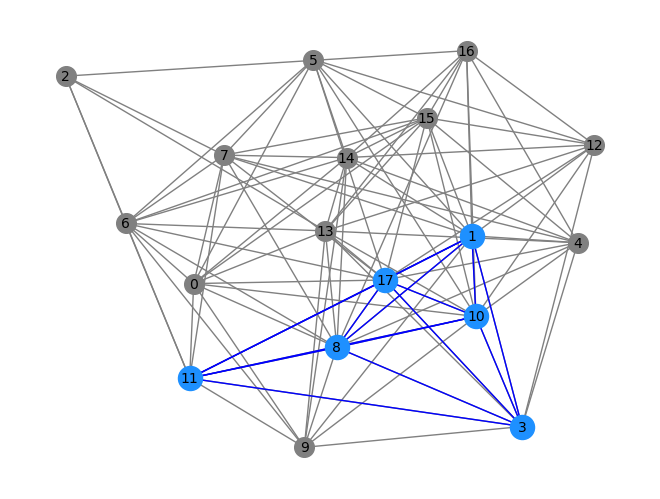

In [5]:
max_clique.plot_subgraph(graph, clique_set[-3])

## 附录

[1] N. Malod-Dognin, R. Andonov, and N. Yanev, in International Symposium on Experimental
Algorithms (Springer, 2010), pp. 106–117

[2]M. G. Ravetti and P. Moscato, PloS One 3, e3111 (2008).

[3] Q. Wu and J.-K. Hao, European Journal of Operational Research 242, 693 (2015)